In [89]:
%matplotlib inline
from matplotlib import pyplot as plt, cm
import cv2
import numpy as np
from bs4 import BeautifulSoup
import requests
import mahotas
import cPickle
import glob
from skimage import exposure
from imutils import convenience
from scipy.spatial import distance as dist

In [4]:
soup = BeautifulSoup(open("pokemon_list.html").read())

In [6]:
names = []

# loop over all link elements
for link in soup.findAll("a"):
	# update the list of pokemon names
	names.append(link.text)

# loop over the pokemon names
for name in names:
	# initialize the parsed name as just the lowercase
	# version of the pokemon name
	parsedName = name.lower()
 
	# if the name contains an apostrophe (such as in
	# Farfetch'd, just simply remove it)
	parsedName = parsedName.replace("'", "")
 
	# if the name contains a period followed by a space
	# (as is the case with Mr. Mime), then replace it
	# with a dash
	parsedName = parsedName.replace(". ", "-")
 
	# handle the case for Nidoran (female)
	if name.find(u'\u2640') != -1:
		parsedName = "nidoran-f"
 
	# and handle the case for Nidoran (male)
	elif name.find(u'\u2642') != -1:
		parsedName = "nidoran-m"

	# construct the URL to download the sprite
	print "[x] downloading %s" % (name)
	url = "http://img.pokemondb.net/sprites/red-blue/normal/%s.png" % (parsedName)
	r = requests.get(url)
 
	# if the status code is not 200, ignore the sprite
	if r.status_code != 200:
		print "[x] error downloading %s" % (name)
		continue
 
	# write the sprite to file
	f = open("./data/pocketmon/" + "%s.png" % (name.lower()), "wb")
	f.write(r.content)
	f.close()

[x] downloading Ivysaur
[x] downloading Venusaur
[x] downloading Charmander
[x] downloading Charmeleon
[x] downloading Charizard
[x] downloading Squirtle
[x] downloading Wartortle
[x] downloading Blastoise
[x] downloading Caterpie
[x] downloading Metapod
[x] downloading Butterfree
[x] downloading Weedle


In [8]:
ls -ltrh ./data/pocketmon/

total 96
-rw-r--r--  1 dikien  staff   742B  5 15 19:42 venusaur.png
-rw-r--r--  1 dikien  staff   506B  5 15 19:42 ivysaur.png
-rw-r--r--  1 dikien  staff   463B  5 15 19:42 charmander.png
-rw-r--r--  1 dikien  staff   536B  5 15 19:42 charmeleon.png
-rw-r--r--  1 dikien  staff   720B  5 15 19:42 charizard.png
-rw-r--r--@ 1 dikien  staff   535B  5 15 19:42 wartortle.png
-rw-r--r--  1 dikien  staff   405B  5 15 19:42 squirtle.png
-rw-r--r--  1 dikien  staff   330B  5 15 19:42 caterpie.png
-rw-r--r--  1 dikien  staff   759B  5 15 19:42 blastoise.png
-rw-r--r--  1 dikien  staff   332B  5 15 19:42 metapod.png
-rw-r--r--  1 dikien  staff   363B  5 15 19:42 weedle.png
-rw-r--r--@ 1 dikien  staff   691B  5 15 19:42 butterfree.png


In [11]:
class ZernikeMoments:
	def __init__(self, radius):
		# store the size of the radius that will be
		# used when computing moments
		self.radius = radius
 
	def describe(self, image):
		# return the Zernike moments for the image
		return mahotas.features.zernike_moments(image, self.radius)

경로 : ./data/pocketmon/blastoise.png
포켓몬 이름 : blastoise
모멘트 : [ 0.31830989  0.00179148  0.00043144  0.00113238  0.00361896  0.00424343
  0.00087058  0.0020337   0.00283156  0.00551625  0.00643317  0.00589648
  0.00151672  0.00314757  0.00353512  0.00526546  0.00750582  0.00871404
  0.00772448  0.00378075  0.00241332  0.00452702  0.00384856  0.0066971
  0.00239698]
the dim of moments is (25,)


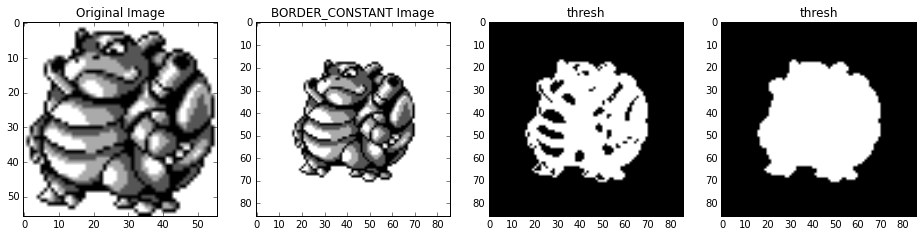

In [27]:
spritePath = glob.glob("./data/pocketmon/*.png")[0]
print "경로 : %s" %spritePath
pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")
print "포켓몬 이름 : %s" %pokemon
image = cv2.imread(spritePath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(16,12))
plt.subplot(141), plt.imshow(image, cmap = 'gray')
plt.title('Original Image')

image = cv2.copyMakeBorder(image, 15, 15, 15, 15, cv2.BORDER_CONSTANT, value = 255)
plt.subplot(142), plt.imshow(image, cmap = 'gray')
plt.title('BORDER_CONSTANT Image')


thresh = cv2.bitwise_not(image)
thresh[thresh > 0] = 255
plt.subplot(143), plt.imshow(thresh, cmap = 'gray')
plt.title('thresh')

outline = np.zeros(image.shape, dtype = "uint8")
(cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
cv2.drawContours(outline, [cnts], -1, 255, -1)
plt.subplot(144), plt.imshow(outline, cmap = 'gray')
plt.title('thresh')

desc = ZernikeMoments(21)

moments = desc.describe(outline)
print "모멘트 : %s" %str(moments)
print "the dim of moments is %s" %str(moments.shape)

In [28]:
# initialize our descriptor (Zernike Moments with a radius
# of 21 used to characterize the shape of our pokemon) and
# our index dictionary
desc = ZernikeMoments(21)
index = {}

# loop over the sprite images
for spritePath in glob.glob("./data/pocketmon/*.png"):
	# parse out the pokemon name, then load the image and
	# convert it to grayscale
	pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")
	image = cv2.imread(spritePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
	# pad the image with extra white pixels to ensure the
	# edges of the pokemon are not up against the borders
	# of the image
	image = cv2.copyMakeBorder(image, 15, 15, 15, 15,
		cv2.BORDER_CONSTANT, value = 255)
 
	# invert the image and threshold it
	thresh = cv2.bitwise_not(image)
	thresh[thresh > 0] = 255

	# initialize the outline image, find the outermost
	# contours (the outline) of the pokemone, then draw
	# it
	outline = np.zeros(image.shape, dtype = "uint8")
	(cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
	cv2.drawContours(outline, [cnts], -1, 255, -1)

	# compute Zernike moments to characterize the shape
	# of pokemon outline, then update the index
	moments = desc.describe(outline)
	index[pokemon] = moments
    
f = open("./data/pocketmon/db.index", "w")
f.write(cPickle.dumps(index))
f.close()

In [30]:
ls -al ./data/pocketmon/*.index

-rw-r--r--  1 dikien  staff  7300  5 15 20:13 ./data/pocketmon/db.index


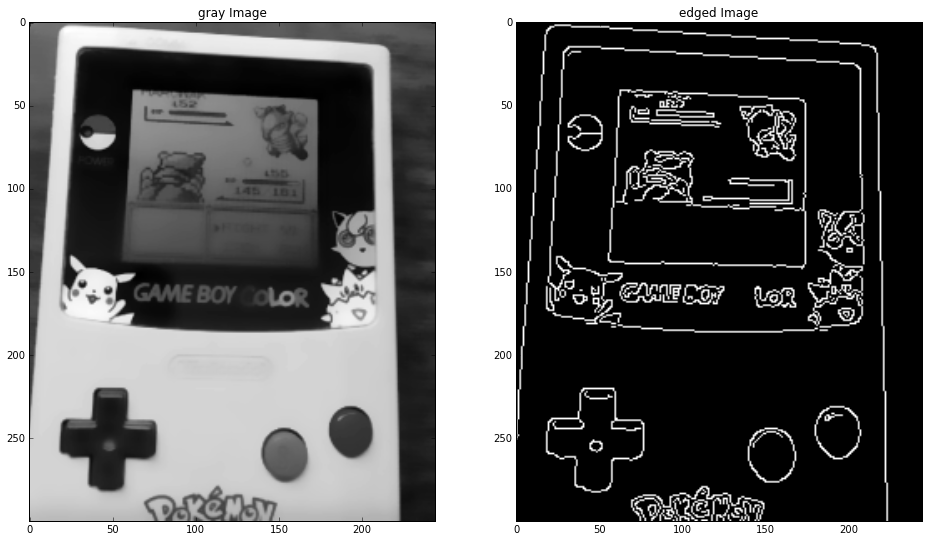

In [32]:
# load the query image, compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread("./data/pocketmon/gameboy.png")
ratio = image.shape[0] / 300.0
orig = image.copy()
image = convenience.resize(image, height = 300)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Bilateral filtering has the nice property of removing noise in the image while still preserving the actual edges. 
# The edges are important since we will need them to find the screen in the Game Boy image.
gray = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(gray, 30, 200)

plt.figure(figsize=(16,12))
plt.subplot(121), plt.imshow(gray, cmap = 'gray')
plt.title('gray Image')
plt.subplot(122), plt.imshow(edged, cmap = 'gray')
plt.title('edged Image')

In [33]:
# find contours in the edged image, keep only the largest
# ones, and initialize our screen contour
(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

In [34]:
# loop over our contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
# The precision is an important value to consider. 
# If you intend on applying this code to your own projects, you’ll likely have to play around with the precision value.
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
	# if our approximated contour has four points, then
	# we can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break

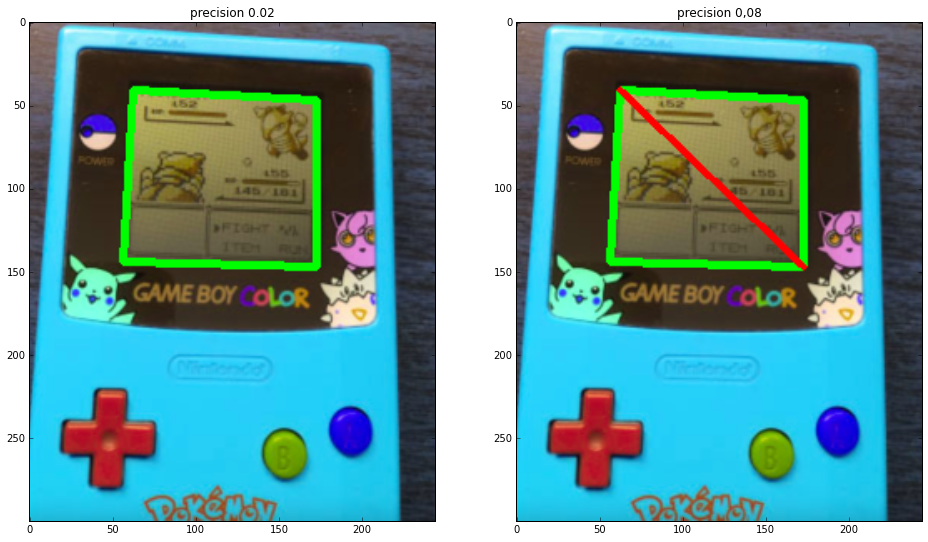

In [56]:
image_bk = image.copy()
test = cv2.approxPolyDP(c, 0.2 * peri, True)

cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 3)
cv2.drawContours(image_bk, [test], -1, (255, 0, 0), 3)

plt.figure(figsize=(16,12))
plt.subplot(121), plt.imshow(image, cmap = 'gray')
plt.title('precision 0.02')
plt.subplot(122), plt.imshow(image_bk, cmap = 'gray')
plt.title('precision 0,08')

In [69]:
print "총 %s개의 largest contours를 찾음" %len(cnts)
print "찾은 영역 : %s" %str(len(c))
print "꼭지점 : %s" %str(cv2.approxPolyDP(c, 0.02 * peri, True))
print "   y    x   왼쪽위로부터 시계 반대방향"
print screenCnt.reshape(4, 2)
print screenCnt.reshape(4, 2).argmin(0)
print screenCnt.reshape(4, 2).argmin(1)
print screenCnt.reshape(4, 2).sum(axis = 1)

총 10개의 largest contours를 찾음
찾은 영역 : 69
꼭지점 : [[[ 62  41]]

 [[ 56 144]]

 [[172 147]]

 [[172  47]]]
   y    x   왼쪽위로부터 시계 반대방향
[[ 62  41]
 [ 56 144]
 [172 147]
 [172  47]]
[1 0]
[1 0 1 1]
[103 200 319 219]


In [71]:
# we have no guarantee of the order of the points. 
# There is no guarantee that the top-left point is the first point in the contour list. 

# now that we have our screen contour, we need to determine
# the top-left, top-right, bottom-right, and bottom-left
# points so that we can later warp the image -- we'll start
# by reshaping our contour to be our finals and initializing
# our output rectangle in top-left, top-right, bottom-right,
# and bottom-left order
pts = screenCnt.reshape(4, 2)
rect = np.zeros((4, 2), dtype = "float32")
 
# the top-left point has the smallest sum whereas the
# bottom-right has the largest sum
s = pts.sum(axis = 1)
rect[0] = pts[np.argmin(s)] # 왼쪽 위
rect[2] = pts[np.argmax(s)] # 오른쪽 아래
 
# compute the difference between the points -- the top-right
# will have the minumum difference and the bottom-left will
# have the maximum difference
diff = np.diff(pts, axis = 1)
rect[1] = pts[np.argmin(diff)] # 오른쪽 위
rect[3] = pts[np.argmax(diff)] # 왼쪽 아래
 
# multiply the rectangle by the original ratio
rect *= ratio

In [84]:
print s
print np.argmin(s)
print pts[np.argmin(s)]
print np.argmax(s)
print pts[np.argmax(s)]
# 왼쪽위부터 시계방향이고 이런 순서라야지 perspective transformation를 적용할 수 있음
print pts
print rect

[103 200 319 219]
0
[62 41]
2
[172 147]
[[ 62  41]
 [ 56 144]
 [172 147]
 [172  47]]
[[ 168.43333435  111.3833313 ]
 [ 467.2666626   127.68333435]
 [ 467.2666626   399.3500061 ]
 [ 152.1333313   391.20001221]]


In [87]:
# now that we have our rectangle of points, let's compute
# the width of our new image
(tl, tr, br, bl) = rect
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
 
# ...and now for the height of our new image
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
 
# take the maximum of the width and height values to reach
# our final dimensions
maxWidth = max(int(widthA), int(widthB))
maxHeight = max(int(heightA), int(heightB))
 
# construct our destination points which will be used to
# map the screen to a top-down, "birds eye" view
dst = np.array([
	[0, 0],
	[maxWidth - 1, 0],
	[maxWidth - 1, maxHeight - 1],
	[0, maxHeight - 1]], dtype = "float32")
 
# calculate the perspective transform matrix and warp
# the perspective to grab the screen
M = cv2.getPerspectiveTransform(rect, dst)
warp = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))

In [78]:
print M
print rect
print dst
print maxWidth
print maxHeight

[[  1.01743376e+00   5.92679938e-02  -1.77971226e+02]
 [ -5.72863450e-02   1.05024944e+00  -1.07331352e+02]
 [ -1.12855478e-04   1.88751579e-04   1.00000000e+00]]
[[ 168.43333435  111.3833313 ]
 [ 467.2666626   127.68333435]
 [ 467.2666626   399.3500061 ]
 [ 152.1333313   391.20001221]]
[[   0.    0.]
 [ 314.    0.]
 [ 314.  279.]
 [   0.  279.]]
315
280


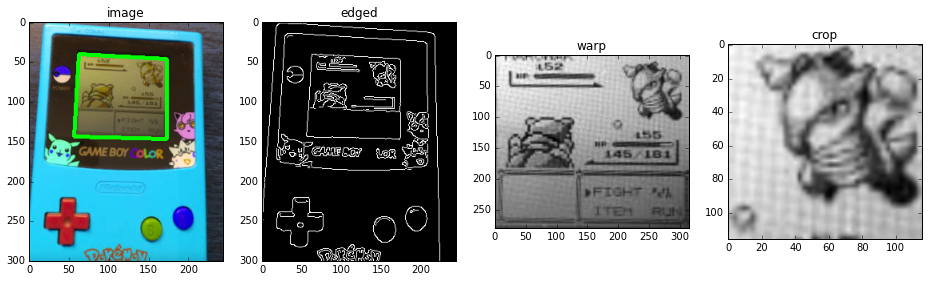

In [88]:
# convert the warped image to grayscale and then adjust
# the intensity of the pixels to have minimum and maximum
# values of 0 and 255, respectively
warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
# This method takes our warped image and then re-scales the gray pixel intensities 
# by finding the minimum and maximum values. 
# The minimum value then becomes black (a value of 0) and the maximum value then becomes white (a value of 255). 
# All pixels that fall into that range are scaled accordingly.
warp = exposure.rescale_intensity(warp, out_range = (0, 255))
 
# the pokemon we want to identify will be in the top-right
# corner of the warped image -- let's crop this region out
(h, w) = warp.shape
(dX, dY) = (int(w * 0.4), int(h * 0.45))
crop = warp[10:dY, w - dX:w - 10]
 
# save the cropped image to file
cv2.imwrite("./data/pocketmon/cropped.png", crop)
 
# show our images
plt.figure(figsize=(16,12))
plt.subplot(141), plt.imshow(image, cmap = 'gray')
plt.title('image')
plt.subplot(142), plt.imshow(edged, cmap = 'gray')
plt.title('edged')
plt.subplot(143), plt.imshow(warp, cmap = 'gray')
plt.title('warp')
plt.subplot(144), plt.imshow(crop, cmap = 'gray')
plt.title('crop')

In [90]:
class Searcher:
	def __init__(self, index):
		# store the index that we will be searching over
		self.index = index
 
	def search(self, queryFeatures):
		# initialize our dictionary of results
		results = {}
 
		# loop over the images in our index
		for (k, features) in self.index.items():
			# compute the distance between the query features
			# and features in our index, then update the results
			d = dist.euclidean(queryFeatures, features)
			results[k] = d
 
		# sort our results, where a smaller distance indicates
		# higher similarity
		results = sorted([(v, k) for (k, v) in results.items()])
 
		# return the results
		return results


In [91]:
# load the index
index = open("./data/pocketmon/db.index").read()
index = cPickle.loads(index)

That pokemon is: CHARMANDER


(<matplotlib.axes._subplots.AxesSubplot at 0x111d7eb50>,
 <matplotlib.image.AxesImage at 0x111e31fd0>)

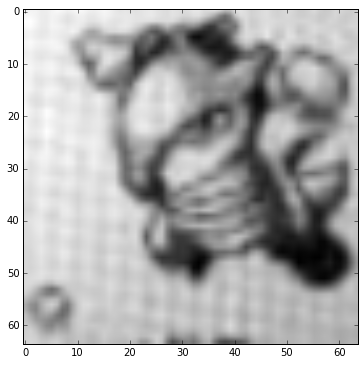

In [94]:
# load the query image, convert it to grayscale, and
# resize it
image = cv2.imread("./data/pocketmon/cropped.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = convenience.resize(image, width = 64)

# threshold the image
# apply adaptive thresholding using the cv2.adaptiveThreshold function and 
# set all pixels below the threshold to black (0) and all pixels above the threshold to white (255)
thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 7)
 
# initialize the outline image, find the outermost
# contours (the outline) of the pokemon, then draw it
outline = np.zeros(image.shape, dtype = "uint8")
(cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
cv2.drawContours(outline, [cnts], -1, 255, -1)

# compute Zernike moments to characterize the shape of pokemon outline
desc = ZernikeMoments(21)
queryFeatures = desc.describe(outline)
 
# perform the search to identify the pokemon
searcher = Searcher(index)
results = searcher.search(queryFeatures)
print "That pokemon is: %s" % results[0][1].upper()
 
plt.figure(figsize=(8,6))
plt.subplot(111), plt.imshow(image, cmap = 'gray')

In [95]:
results

[(0.20021734106721045, 'charmander'),
 (0.20081559742917296, 'wartortle'),
 (0.2019266990278611, 'charmeleon'),
 (0.2023316053504071, 'ivysaur'),
 (0.23833456689886054, 'butterfree'),
 (0.26592631425747676, 'venusaur'),
 (0.29546589933140294, 'charizard'),
 (0.2982018956405541, 'blastoise'),
 (0.32830751720525586, 'squirtle'),
 (0.4604320587644124, 'weedle'),
 (0.4995501369120292, 'metapod'),
 (0.5731159456005049, 'caterpie')]